## Isentropic Vortex 

> WORK IN PROGRESS !!!

In this example we are going to solve the Euler equations for an isentropic two-dimensional vortex in a full-periodic square domain. Since the problem is not diffusive, the expected behavior is for the vortex to be convected unchanged forever. This is a useful example for testing the diffusive properties of our methods, as well as its numerical stability.

\begin{equation}
    \begin{array}{c}
        \rho_t + \nabla \cdot (\rho u) = 0 \\
        (\rho \mathbf{u})_t + (\mathbf{u} \cdot \nabla)(\rho \mathbf{u}) + \nabla p = 0 \\
        (\rho e)_t + \nabla \cdot(\mathbf{u} (  \rho e + p )) = 0
    \end{array}
\end{equation}

The inputs to the network will be the independent variables $x$, $y$ and $t$ and the outputs will be the conserved variables $\rho$, $\rho \mathbf{u}$ and $\rho e$ where $\rho$ is the density, $\mathbf{u} = (u, v)$ is the velocity and $e$ is the specific energy.

![](http://hypar.github.io/Solution_2DNavStokLowMachVortexPETSc.gif)

In [ ]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 

import torch
cuda = True
device = "cuda" if torch.cuda.is_available() and cuda else "cpu"

First we define our PDE and set the values for training.

In [ ]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        drodt = grads['ro']['t']
        drudt = grads['ru']['t']
        drvdt = grads['rv']['t']
        dredt = grads['re']['t']
        drudx = grads['ru']['x']
        drudy = grads['ru']['y']
        drvdx = grads['rv']['x']
        drvdy = grads['rv']['y']
        
        # calcular p y sacar grads
        
        
        # caluclar repu, repv y sacar grads
        
        
        return [
            dropdt + drurdx + drvdy,
            drudp + u*drudx + v*drudy + dpdx,
            drvdt + u*drvdx + v*drvdy + dpdy,
            dredt + drepudx + drepvdy 
        ]

# instanciate pde
pde = MyPDE(inputs=['x', 'y', 't'], outputs=['ro', 'ru', 'rv', 're'])

# define input values
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,10)

pde.setValues({'x': x, 'y': y, 't': t})
pde.setValues({'x': x, 'y': y, 't': t}, train=False)

Boundary conditions.

In [ ]:
# periodic b.c for the space dimension

x1, x2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_x', {'x': x1, 'y': y, 't': t}, {'x': x2, 'y':y, 't': t})
pde.addBoco(boco)

y1, y2 = np.array([0]), np.array([1])
boco = PeriodicBoco('boco_y', {'x': x, 'y': y1, 't': t}, {'x': x, 'y':y2, 't': t})
pde.addBoco(boco)

# initial condition (dirichlet for temporal dimension)
gamma, Ma = 1.4, 0.6
Rgas = 1./(gamma*Ma*Ma)
Rc, C = 0.2, -0.1   

ro0 = np.zeros((len(y)*len(x)))
ru0 = np.zeros((len(y)*len(x)))
rv0 = np.zeros((len(y)*len(x)))
re0 = np.zeros((len(y)*len(x)))
for i, _y in enumerate(y):
    for j, _x in enumerate(x):
        # vortex center at (0.5, 0.5)
        x1, x2 = x[j] - 0.5, y[i] - 0.5
        
        e = -(x1*x1+x2*x2)/(2.*Rc*Rc)
        
        ro = 1. 
        T = 1.
        p = ro*Rgas*T+ro*C*C/(Rc*Rc)*math.exp(e)
        u = 1.+C/ro*e*math.exp(e)*(-2.*x2/(2*Rc*Rc))
        v = 0.-C/ro*e*math.exp(e)*(-2.*x1/(2*Rc*Rc))
        
        ro0[i*len(x) + j] = ro
        ru0[i*len(x) + j] = ro*u
        rv0[i*len(x) + j] = ro*v
        re0[i*len(x) + j] = 0.5*ro*(u*u+v*v) + p/(gamma-1)
        
boco = DirichletBoco('initial_condition', {'x': x, 'y': y, 't': np.array([0])}, {'ro': ro0, 'ru': ru0, 'rv': rv0, 're': re0})
pde.addBoco(boco)

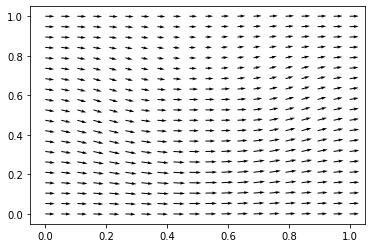

In [ ]:
# visualize initial condition

fig, ax = plt.subplots()
u, v = ru0/ro0, rv0/ro0
u, v = u.reshape(len(y),len(x)), v.reshape(len(y),len(x))
q = ax.quiver(x, y, u, v)
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')
plt.show()

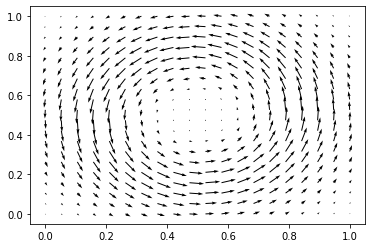

In [ ]:
# removing free-streem velocity component

fig, ax = plt.subplots()
q = ax.quiver(x, y, u - 1, v)
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')
plt.show()

Now we define a topology for our solution and set the training parameters. Then we can find a solution for our PDE.

In [ ]:
# define solution topology
topo = {'layers': 5, 'neurons': 256, 'activations': 'relu'}
pde.buildSolution(topo)

# set optimization parameters
pde.compile(epochs=100, lr=3e-4, batch_size=32)

In [ ]:
# find the solution
hist = pde.solve(device, 'vortex_best.pth') 

NameError: name 'dropdt' is not defined

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.plot(hist['val_loss'], label="val_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

Finally, we can evaluate our solution.

In [ ]:
# evaluate the solution
pde.load_state_dict('sh_diff_best.pth')
x = np.linspace(-1,1,50)
y = np.linspace(0,1,25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,60))
g = np.array([0.1])
p1 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax1.imshow(p1.reshape((len(y),len(x))), vmin=p1.min(), vmax=p1.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax1.set_title(f"$\\Gamma$ = 0.1")
g = np.array([0.001])
p2 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax2.imshow(p2.reshape((len(y),len(x))), vmin=p2.min(), vmax=p2.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax2.set_title(f"$\\Gamma$ = 0.001")
g = np.array([0.000001])
p3 = pde.evaluate({'x': x, 'y': y, 'g': g}, device)
ax3.imshow(p3.reshape((len(y),len(x))), vmin=p3.min(), vmax=p3.max(), origin='lower',
           extent=[x.min(), x.max(), y.min(), y.max()])
ax3.set_title(f"$\\Gamma$ = 0.000001")
#plt.colorbar()
plt.show()

In [ ]:
# experimental results
exp = {
    'x': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'g_0.1': [1.989,1.402,1.146,0.946,0.775,0.621,0.480,0.349,0.227,0.111,0.0],
    'g_0.001': [2.0000,1.9990,1.9997,1.985,1.841,0.951,0.154,0.001,0.0,0.0,0.0],
    'g_0.000001': [2.0000,2.0,2.0,1.999,1.964,1.0,0.036,0.001,0.0,0.0,0.0]
}

x = np.linspace(-1,1,40)
y = np.array([0])
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.1])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.1")
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.001])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.001")
p = pde.evaluate({'x': x, 'y': y, 'g': np.array([0.000001])}, device)
plt.plot(x,p, label=f"$\\Gamma$ = 0.000001")

x1, p1, gamma = [], [], 0.1
for i in range(len(x)): 
    if x[i] < 0:
        x1.append(x[i])
        p1.append(1.+math.tanh(a*(2*x[i]+1)))
x1, p1 = np.array(x1), np.array(p1)
plt.plot(x1,p1)

plt.plot(exp['x'], exp['g_0.1'], '.k')
plt.plot(exp['x'], exp['g_0.001'], '.k')
plt.plot(exp['x'], exp['g_0.000001'], '.k', label="experimental")
plt.grid()
plt.xlabel('x (y = 0)')
plt.ylabel('$\\phi$       ', rotation=np.pi/2)
plt.legend()
plt.show()